<a href="https://colab.research.google.com/github/DhafinRA/ML-Upatik/blob/main/Food_Classification_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT DEPENDENCIES

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import ResNet50V2
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [40]:
#HYPERPARAMETER

EPOCHS = 25
LOSS = CategoricalCrossentropy()
OPTIMIZERS = Adam(learning_rate=0.0001)
input_shape = (256,256,3)

Labeling Photo Using ImageDataGenerator

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    height_shift_range=0.2,
                                    width_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

Show All Classes

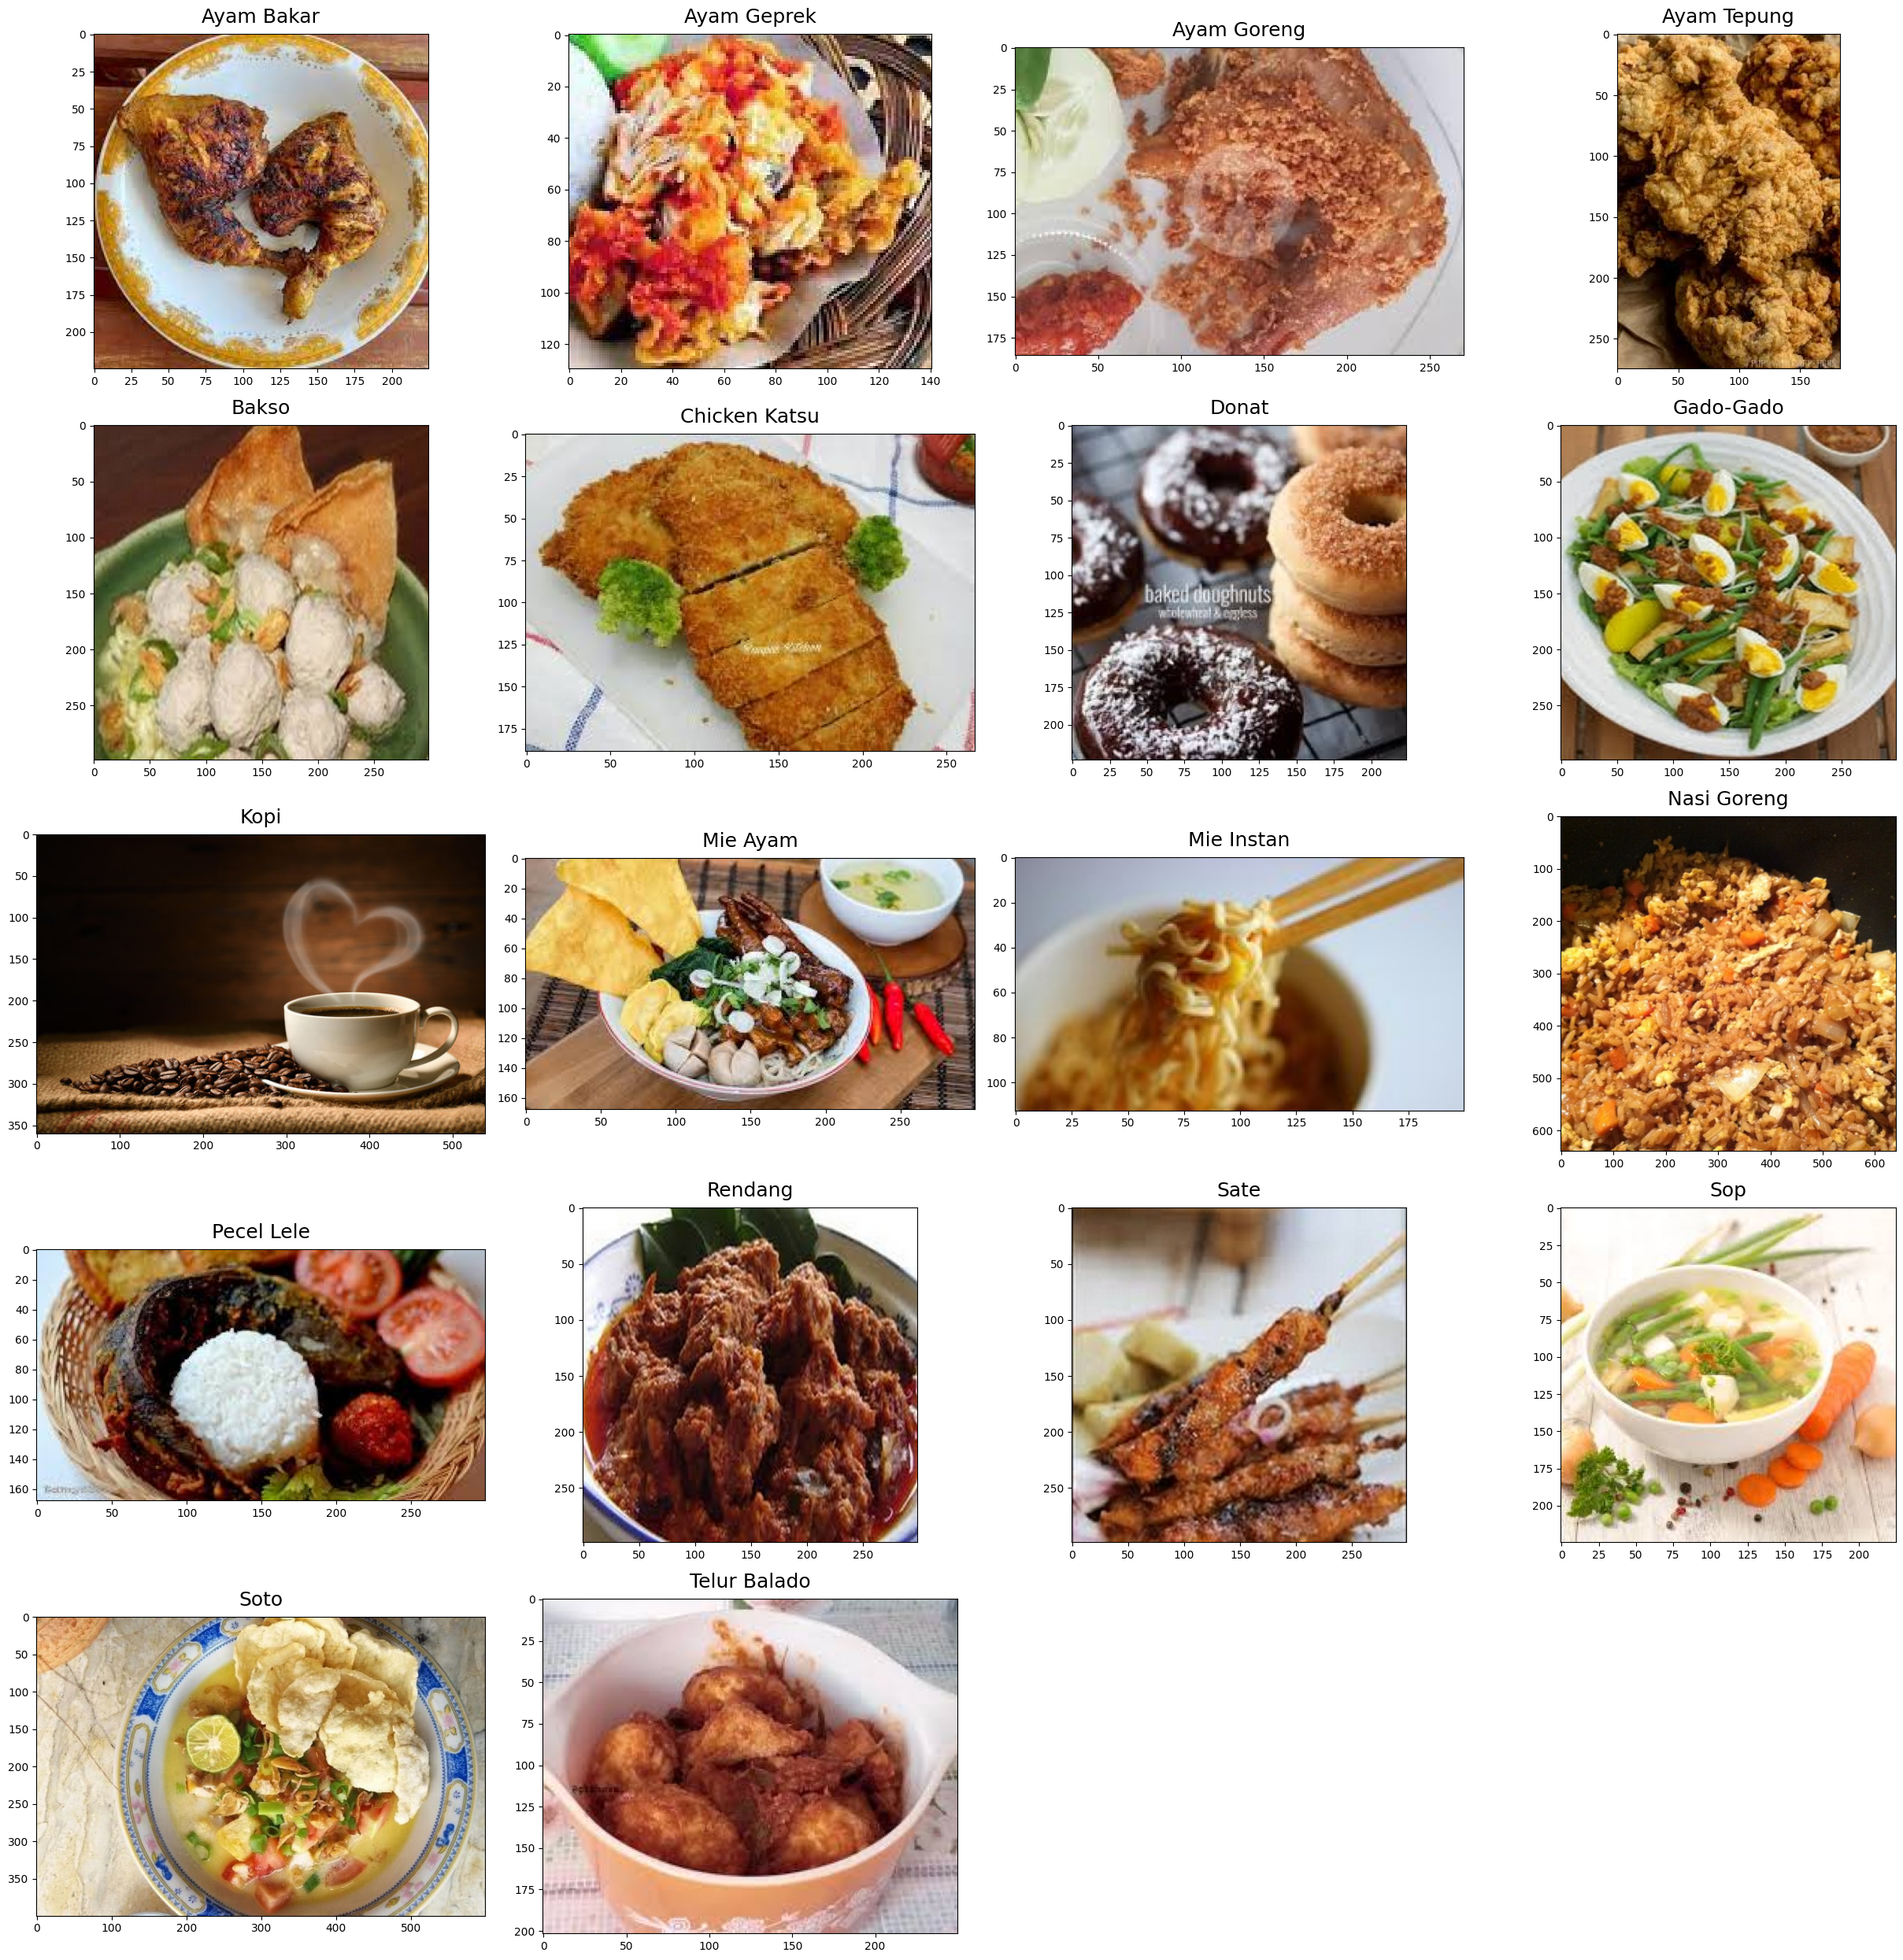

In [23]:
train_dir = "Image Eye\Train"
test_dir = "Image Eye\Test"
images = []
labels = []

for food_folder in sorted(os.listdir(train_dir)):
    food_items = os.listdir(train_dir + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_dir,food_folder,food_selected))

fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('\\')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    labels.append(category)

plt.tight_layout()

In [42]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=False)

Found 4832 images belonging to 18 classes.
Found 1214 images belonging to 18 classes.


Making Callbacks for Training

In [25]:
# class myCallback(tf.keras.callbacks.Callback):
#         def on_epoch_end(self, epoch, logs={}):
#             if (logs.get('val_accuracy') > 0.83 and logs.get('accuracy')>0.83):
#                 print('\naccuracy and validation accuracy reached 83%,so cancelling training!')
#                 self.model.stop_training = True
                
# callbacks = myCallback()

model_checkpoint_callback = ModelCheckpoint(
    filepath='Model/model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    restore_best_weights = True,
)

In [41]:
resnet = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
total_layers = len(resnet.layers)
fn_layers = round(int(0.5 * total_layers))
for layer in resnet.layers[:fn_layers]:
    layer.trainable = False

Making Model

In [59]:
model = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(512,activation='relu'),
    Dense(256,activation='relu'),
    Dense(18,activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 512)               1049088   
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 18)                4626      
                                                                 
Total params: 24,749,842
Trainable params: 22,535,442
Non-trainable params: 2,214,400
__________________________________

In [60]:
# model.load_weights('Weights/weight')
model.compile(loss=LOSS,optimizer=OPTIMIZERS,metrics=['accuracy'])
history = model.fit(train_generator,epochs=EPOCHS,validation_data=test_generator)

Epoch 1/20
151/151 [==============================] - 75s 464ms/step - loss: 0.2644 - accuracy: 0.9303 - val_loss: 0.9541 - val_accuracy: 0.8196
Epoch 2/20
151/151 [==============================] - 68s 448ms/step - loss: 0.1019 - accuracy: 0.9679 - val_loss: 0.9339 - val_accuracy: 0.8229
Epoch 3/20
151/151 [==============================] - 68s 447ms/step - loss: 0.1008 - accuracy: 0.9725 - val_loss: 0.5674 - val_accuracy: 0.8748
Epoch 4/20
151/151 [==============================] - 65s 431ms/step - loss: 0.0810 - accuracy: 0.9737 - val_loss: 0.5325 - val_accuracy: 0.8756
Epoch 5/20
151/151 [==============================] - 67s 441ms/step - loss: 0.0825 - accuracy: 0.9760 - val_loss: 0.5532 - val_accuracy: 0.8756
Epoch 6/20
151/151 [==============================] - 66s 436ms/step - loss: 0.0602 - accuracy: 0.9795 - val_loss: 0.4629 - val_accuracy: 0.8954
Epoch 7/20
151/151 [==============================] - 66s 435ms/step - loss: 0.0595 - accuracy: 0.9797 - val_loss: 0.6700 - val_ac

In [31]:
# model.save_weights('Weights/weight')

RESULTS

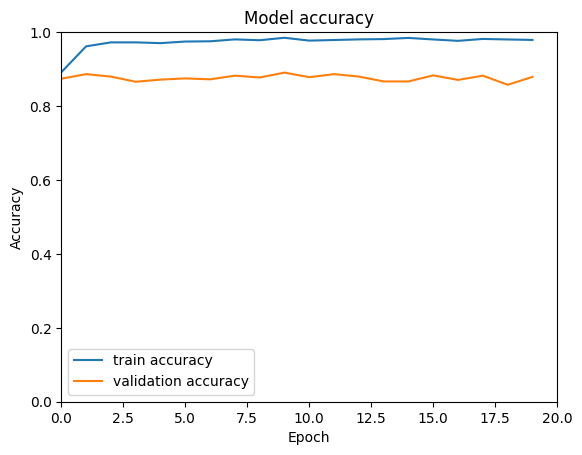

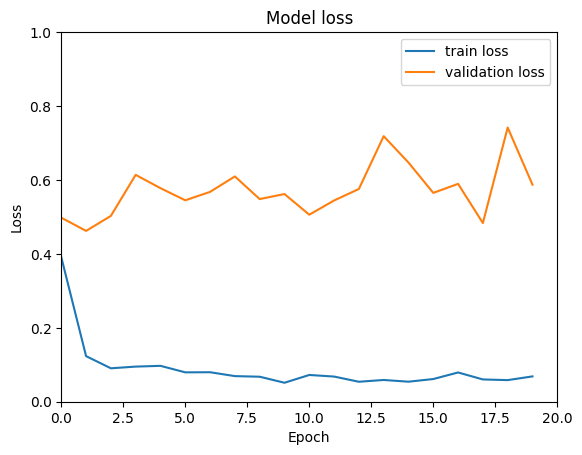

In [58]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xlim(0,EPOCHS)
    plt.ylim(0,1)
    plt.legend(loc='best')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim(0,EPOCHS)
    plt.ylim(0,1)
    plt.legend(loc='best')
    plt.show()

plot_accuracy(history)
plot_loss(history)

In [50]:
predictions = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions)
clr = classification_report(test_generator.labels, predictions, target_names=test_generator.class_indices, zero_division=0)

38/38 [==============================] - 7s 157ms/step


CONFUSION MATRIX

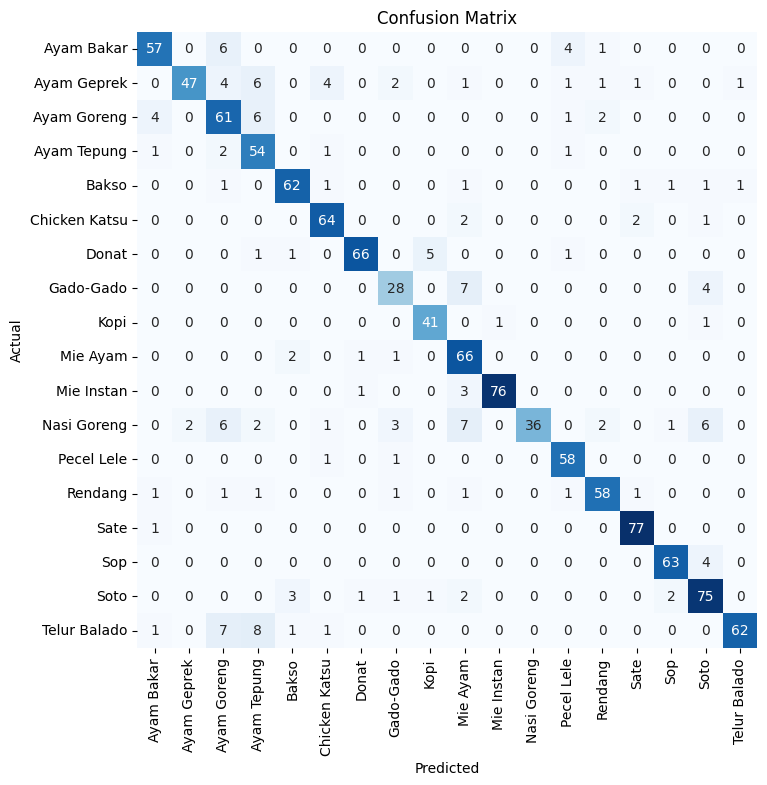

In [51]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(18) + 0.5, labels=test_generator.class_indices, rotation=90)
plt.yticks(ticks=np.arange(18) + 0.5, labels=test_generator.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [55]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

   Ayam Bakar       0.88      0.84      0.86        68
  Ayam Geprek       0.96      0.69      0.80        68
  Ayam Goreng       0.69      0.82      0.75        74
  Ayam Tepung       0.69      0.92      0.79        59
        Bakso       0.90      0.90      0.90        69
Chicken Katsu       0.88      0.93      0.90        69
        Donat       0.96      0.89      0.92        74
    Gado-Gado       0.76      0.72      0.74        39
         Kopi       0.87      0.95      0.91        43
     Mie Ayam       0.73      0.94      0.82        70
   Mie Instan       0.99      0.95      0.97        80
  Nasi Goreng       1.00      0.55      0.71        66
   Pecel Lele       0.87      0.97      0.91        60
      Rendang       0.91      0.89      0.90        65
         Sate       0.94      0.99      0.96        78
          Sop       0.94      0.94      0.94        67
         Soto    

VISUALIZING WHAT CONVOLUTIONAL LAYER HAS DONE TO OUR DATASET

In [53]:
layer_names = [layer.name for layer in model.layers[1:10]]  # Names of layers for plotting
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # Number of features in the feature map
    size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features)
    n_cols = n_features // 8  # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, 8 * size))
    for col in range(n_cols):  # Tiles each filter into a big horizontal grid
        for row in range(8):
            channel_image = layer_activation[0, :, :, col * 8 + row]
            channel_image -= channel_image.mean()  # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()

NameError: name 'activations' is not defined